<a href="https://colab.research.google.com/github/viki-m13/Momentum-Top-2-Selector-Multi-Asset-/blob/main/Momentum_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNIVERSE_MODE             : ALL
Benchmark                 : SPY
Trading days per year     : 252
USE_UNDERPERFORMERS_ONLY : False


/tmp/ipython-input-380182836.py:160: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(



Final tradable universe (105 tickers):
['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'IVV', 'VOO', 'QQQ', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO', 'AGG', 'BND', 'TLT', 'IEF', 'LQD', 'HYG', 'GLD', 'SLV', 'MTUM', 'USMV', 'VLUE', 'QUAL', 'VNQ', 'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'META', 'NVDA', 'INTC', 'CSCO', 'ORCL', 'ADBE', 'IBM', 'TXN', 'AVGO', 'QCOM', 'AMD', 'AMAT', 'JPM', 'BAC', 'WFC', 'C', 'MS', 'GS', 'USB', 'PNC', 'AXP', 'BLK', 'KO', 'PEP', 'MCD', 'SBUX', 'PG', 'WMT', 'COST', 'TGT', 'NKE', 'JNJ', 'PFE', 'MRK', 'ABBV', 'LLY', 'UNH', 'ABT', 'TMO', 'BMY', 'BA', 'CAT', 'MMM', 'HON', 'GE', 'LMT', 'UNP', 'UPS', 'FDX', 'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'PSX', 'CLF', 'NEM', 'NEE', 'DUK', 'SO', 'D', 'O', 'PLD', 'SPG', 'T', 'VZ', 'CMCSA', 'BTC-USD', 'ETH-USD']

=== All Assets Momentum (L=20, top_k=2) Performance ===
Days                : 1842
Total return        : 2347.69%
CAGR                :  54.88%
Annualized vol      :  43.85%
Sharpe (rf=0)       :   1.22
Max 

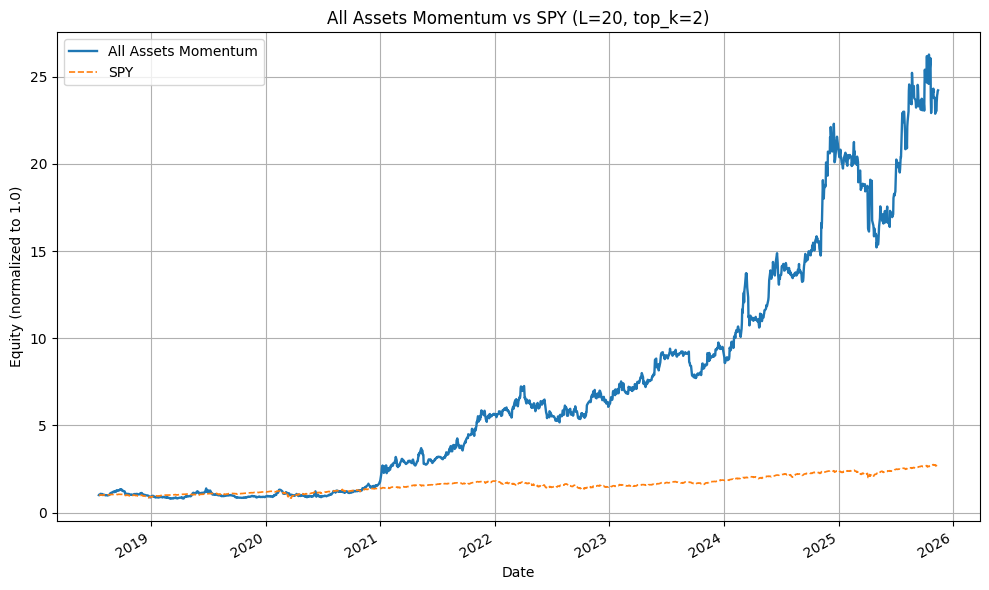

In [13]:
#!/usr/bin/env python3
# Final Sector/Stock/ETF/Crypto Momentum Model
# Fixed params: L = 20, top_k = 2
#
# Universe modes (case-insensitive):
#   "SECTORS" -> SPDR sector ETFs only
#   "ETFS"    -> broader ETF universe (sectors + popular allocation ETFs)
#   "STOCKS"  -> user-defined stock list
#   "CRYPTO"  -> crypto universe (vs BTC-USD)
#   "ALL"     -> sectors + ETFs + stocks + crypto
#
# Toggle:
#   USE_UNDERPERFORMERS_ONLY:
#       - False: use all assets in chosen universe
#       - True : filter to assets that historically underperform
#               the benchmark (SPY or BTC-USD) over the full sample.
#
# Strategy:
#   - Compute daily momentum over last 20 days (compounded), shifted by 1 day
#   - Each day, go long top_k tickers by momentum, equal-weighted
#   - Compare to benchmark buy & hold

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
DEFAULT_EQUITY_BENCH = "SPY"
CRYPTO_BENCH        = "BTC-USD"

UNIVERSE_MODE = "ALL"      # "SECTORS" | "ETFS" | "STOCKS" | "CRYPTO" | "ALL" (case-insensitive)
USE_UNDERPERFORMERS_ONLY = False  # True = only assets that underperformed benchmark

START_DATE = "2010-01-01"

# Sector ETFs (SPDR)
SECTOR_TICKERS = [
    "XLB", "XLC", "XLE", "XLF", "XLI",
    "XLK", "XLP", "XLRE", "XLU", "XLV", "XLY"
]

# Broader ETF universe for allocation (includes sectors + popular core ETFs)
ETF_TICKERS = [
    # Core US equity
    "SPY", "IVV", "VOO", "QQQ", "IWM",

    # International equity
    "EFA", "EEM", "VEA", "VWO",

    # Fixed income
    "AGG", "BND", "TLT", "IEF", "LQD", "HYG",

    # Real assets / commodities
    "GLD", "SLV",

    # Factor / style
    "MTUM", "USMV", "VLUE", "QUAL",

    # REIT
    "VNQ",
] + SECTOR_TICKERS  # include all sector ETFs as part of the ETF universe

# User stock universe (edit as you like)
STOCK_TICKERS = [
    # Tech
    "AAPL", "MSFT", "GOOGL", "GOOG", "META", "NVDA", "INTC", "CSCO", "ORCL",
    "ADBE", "IBM", "TXN", "AVGO", "QCOM", "AMD", "AMAT",
    # Financials
    "JPM", "BAC", "WFC", "C", "MS", "GS", "USB", "PNC", "AXP", "BLK",
    # Consumer Staples / Discretionary
    "KO", "PEP", "MCD", "SBUX", "PG", "WMT", "COST", "TGT", "NKE",
    # Healthcare
    "JNJ", "PFE", "MRK", "ABBV", "LLY", "UNH", "ABT", "TMO", "BMY",
    # Industrials
    "BA", "CAT", "MMM", "HON", "GE", "LMT", "UNP", "UPS", "FDX",
    # Energy / Materials
    "XOM", "CVX", "COP", "SLB", "EOG", "PSX", "CLF", "NEM",
    # Utilities / REITs
    "NEE", "DUK", "SO", "D", "O", "PLD", "SPG",
    # Telecom / Media
    "T", "VZ", "CMCSA"
]

# Crypto universe
CRYPTO_TICKERS = [
    "BTC-USD", "ETH-USD"
]

# Fixed best params
L_LOOKBACK = 20
TOP_K = 2


# ---------------- HELPERS: benchmark & universe ----------------
def get_benchmark_ticker() -> str:
    """Use SPY normally, BTC-USD when in CRYPTO mode."""
    mode = UNIVERSE_MODE.upper()
    if mode == "CRYPTO":
        return CRYPTO_BENCH
    return DEFAULT_EQUITY_BENCH


def get_trading_days_per_year() -> int:
    """Use 252 for traditional markets, 365 for crypto."""
    mode = UNIVERSE_MODE.upper()
    if mode == "CRYPTO":
        return 365
    return 252


def get_universe_tickers(bench_ticker: str) -> (list, str):
    """
    Build the base universe for the chosen UNIVERSE_MODE (excluding benchmark).
    Returns:
        universe_tickers: list of tickers
        universe_label  : human-readable label
    """
    mode = UNIVERSE_MODE.upper()

    if mode == "SECTORS":
        tickers = SECTOR_TICKERS.copy()
        universe_label = "Sector ETFs"
    elif mode == "ETFS":
        tickers = ETF_TICKERS.copy()
        universe_label = "ETF Universe"
    elif mode == "STOCKS":
        tickers = STOCK_TICKERS.copy()
        universe_label = "Stocks"
    elif mode == "CRYPTO":
        tickers = CRYPTO_TICKERS.copy()
        universe_label = "Crypto"
    elif mode == "ALL":
        tickers = SECTOR_TICKERS + ETF_TICKERS + STOCK_TICKERS + CRYPTO_TICKERS
        universe_label = "All Assets"
    else:
        raise ValueError(f"Unknown UNIVERSE_MODE: {UNIVERSE_MODE}")

    # Deduplicate while preserving order
    tickers = list(dict.fromkeys(tickers))

    # Remove benchmark from tradable universe if present
    if bench_ticker in tickers:
        tickers.remove(bench_ticker)

    if not tickers:
        raise ValueError("Universe is empty after removing benchmark.")

    return tickers, universe_label


# ---------------- DATA ----------------
def download_prices(base_tickers, bench_ticker, start=START_DATE):
    """
    Download Adjusted Close prices for base_tickers + bench_ticker,
    and drop any dates where any ticker is missing (common date universe).
    """
    tickers = sorted(set(base_tickers + [bench_ticker]))

    data = yf.download(
        tickers,
        start=start,
        progress=False
    )

    if "Adj Close" in data.columns:
        px = data["Adj Close"]
    else:
        px = data["Close"]

    missing = set(tickers) - set(px.columns)
    if missing:
        raise ValueError(f"Missing price data for: {missing}")

    # Common date universe: drop rows with any NaNs
    px = px[tickers].dropna()

    return px


def compute_returns(px: pd.DataFrame) -> pd.DataFrame:
    """Simple daily returns."""
    return px.pct_change().dropna()


# ---------------- STRATEGY ----------------
def run_momentum_strategy(sector_or_stock_ret: pd.DataFrame,
                          lookback: int = L_LOOKBACK,
                          top_k: int = TOP_K) -> (pd.Series, pd.Series):
    """
    Momentum strategy:
      - Momentum = compounded return over last `lookback` days, shifted by 1 day
      - Each day long the `top_k` tickers with highest momentum (equal-weight)
    Returns:
      - strategy_ret: Series of daily strategy returns
      - chosen_ticker: Series of symbol(s) chosen (if top_k > 1, stored as comma-separated string)
    """
    if lookback < 1:
        raise ValueError("lookback must be >= 1")
    if top_k < 1:
        raise ValueError("top_k must be >= 1")

    # Rolling product of (1 + r) over lookback days
    cum = (1.0 + sector_or_stock_ret).rolling(lookback).apply(np.prod, raw=True) - 1.0
    # Shift one day to avoid look-ahead
    momentum = cum.shift(1).dropna(how="any")

    # Align returns
    ret = sector_or_stock_ret.loc[momentum.index]

    # Rank each day
    ranks = momentum.rank(axis=1, ascending=False, method="first")

    # Binary weights for top_k
    weights = (ranks <= top_k).astype(float)
    weights = weights.div(weights.sum(axis=1), axis=0)  # equal weight top_k

    # Strategy returns: row-wise dot product
    strategy_ret = (weights * ret).sum(axis=1)
    strategy_ret.name = "Momentum_L{}_K{}".format(lookback, top_k)

    # For diagnostics: which tickers were selected
    chosen_list = []
    for dt, row in weights.iterrows():
        chosen = row[row > 0].index.tolist()
        chosen_list.append(",".join(chosen))
    chosen_ticker = pd.Series(chosen_list, index=weights.index, name="chosen")

    return strategy_ret, chosen_ticker


# ---------------- UNDERPERFORMER FILTER ----------------
def select_underperformers(px: pd.DataFrame,
                           bench_ticker: str,
                           min_underperformers: int = TOP_K) -> list:
    """
    From px (prices for many tickers including bench_ticker),
    select tickers whose total return over the full period
    is LOWER than the benchmark's total return.
    Returns a list of underperformer tickers.
    """
    all_tickers = list(px.columns)
    if bench_ticker not in all_tickers:
        raise ValueError(f"{bench_ticker} not in price DataFrame columns.")

    bench_px = px[bench_ticker]
    bench_ret = bench_px.iloc[-1] / bench_px.iloc[0] - 1.0

    under = []
    for t in all_tickers:
        if t == bench_ticker:
            continue
        tr = px[t].iloc[-1] / px[t].iloc[0] - 1.0
        if tr < bench_ret:
            under.append(t)

    if len(under) < min_underperformers:
        raise ValueError(
            f"Only {len(under)} underperformers found (< {min_underperformers}). "
            f"Relax the condition or expand the universe."
        )

    return under


# ---------------- STATS ----------------
def performance_stats(ret: pd.Series,
                      trading_days_per_year: int,
                      name: str = "Strategy"):
    ret = ret.dropna()
    if ret.empty:
        raise ValueError(f"No returns to evaluate for {name}.")

    equity = (1.0 + ret).cumprod()
    total_return = equity.iloc[-1] - 1.0

    n_days = ret.shape[0]
    n_years = n_days / trading_days_per_year

    cagr = equity.iloc[-1] ** (1.0 / n_years) - 1.0 if n_years > 0 else np.nan
    vol = ret.std() * np.sqrt(trading_days_per_year) if ret.std() > 0 else np.nan
    sharpe = (ret.mean() / ret.std()) * np.sqrt(trading_days_per_year) if ret.std() > 0 else np.nan

    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    max_dd = dd.min()

    stats = {
        "name": name,
        "total_return": total_return,
        "CAGR": cagr,
        "ann_vol": vol,
        "Sharpe": sharpe,
        "max_drawdown": max_dd,
        "n_days": n_days,
    }
    return stats, equity


def print_stats(stats):
    print(f"\n=== {stats['name']} Performance ===")
    print(f"Days                : {stats['n_days']}")
    print(f"Total return        : {stats['total_return']*100:6.2f}%")
    print(f"CAGR                : {stats['CAGR']*100:6.2f}%")
    print(f"Annualized vol      : {stats['ann_vol']*100:6.2f}%")
    print(f"Sharpe (rf=0)       : {stats['Sharpe']:6.2f}")
    print(f"Max drawdown        : {stats['max_drawdown']*100:6.2f}%")
    print("=====================================")


# ---------------- PLOTTING ----------------
def plot_equity(equity_strategy,
                equity_bench,
                title="Equity Curve",
                label_strategy="Strategy",
                label_bench="Benchmark"):
    plt.figure(figsize=(10, 6))
    (equity_strategy / equity_strategy.iloc[0]).plot(label=label_strategy, linewidth=1.7)
    (equity_bench / equity_bench.iloc[0]).plot(label=label_bench, linewidth=1.2, linestyle="--")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Equity (normalized to 1.0)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ---------------- MAIN ----------------
def main():
    bench_ticker = get_benchmark_ticker()
    trading_days_per_year = get_trading_days_per_year()

    print(f"UNIVERSE_MODE             : {UNIVERSE_MODE}")
    print(f"Benchmark                 : {bench_ticker}")
    print(f"Trading days per year     : {trading_days_per_year}")
    print(f"USE_UNDERPERFORMERS_ONLY : {USE_UNDERPERFORMERS_ONLY}")

    # 1) Decide base universe
    base_universe, universe_label = get_universe_tickers(bench_ticker)

    # 2) Download prices for base universe + benchmark on a common date set
    px_all = download_prices(base_universe, bench_ticker=bench_ticker, start=START_DATE)

    # 3) Apply underperformer filter if requested
    if USE_UNDERPERFORMERS_ONLY:
        try:
            under = select_underperformers(px_all, bench_ticker=bench_ticker, min_underperformers=TOP_K)
            print(f"\nUnderperformers vs {bench_ticker}: {under}")
            universe = under
            universe_label = universe_label + " (Underperformers)"
        except ValueError as e:
            print(f"\n[WARNING] Underperformer filter failed: {e}")
            print("Falling back to full universe.")
            universe = base_universe
    else:
        universe = base_universe

    print(f"\nFinal tradable universe ({len(universe)} tickers):")
    print(universe)

    # 4) Compute returns
    ret_all = compute_returns(px_all)
    universe_ret = ret_all[universe]
    bench_ret = ret_all[bench_ticker]

    # 5) Run momentum strategy with fixed params (L=20, top_k=2)
    strat_ret, chosen = run_momentum_strategy(universe_ret, lookback=L_LOOKBACK, top_k=TOP_K)

    # 6) Align benchmark to strategy dates
    bench_aligned = bench_ret.loc[strat_ret.index]

    # 7) Performance stats
    strat_stats, strat_equity = performance_stats(
        strat_ret,
        trading_days_per_year,
        name=f"{universe_label} Momentum (L={L_LOOKBACK}, top_k={TOP_K})"
    )
    bench_stats, bench_equity = performance_stats(
        bench_aligned,
        trading_days_per_year,
        name=f"{bench_ticker} Buy & Hold"
    )

    print_stats(strat_stats)
    print_stats(bench_stats)

    # 8) Selection frequency
    print("\nSelection frequency (by ticker):")
    counts = {}
    for row in chosen.dropna():
        for t in row.split(","):
            counts[t] = counts.get(t, 0) + 1
    counts_series = pd.Series(counts).sort_values(ascending=False)
    print(counts_series)

    # 9) Plot equity curves
    plot_equity(
        strat_equity,
        bench_equity,
        title=f"{universe_label} Momentum vs {bench_ticker} (L={L_LOOKBACK}, top_k={TOP_K})",
        label_strategy=f"{universe_label} Momentum",
        label_bench=bench_ticker
    )


if __name__ == "__main__":
    main()


#Only Crypto

*Survivorship Bias

/tmp/ipython-input-224476381.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(



=== Crypto Momentum (L=20, top_k=2) Performance ===
Days                : 1624
Total return        : 52614.27%
CAGR                : 309.04%
Annualized vol      : 120.82%
Sharpe (rf=0)       :   1.74
Max drawdown        : -70.12%

=== BTC-USD Buy & Hold Performance ===
Days                : 1624
Total return        : 657.21%
CAGR                :  57.62%
Annualized vol      :  61.59%
Sharpe (rf=0)       :   1.05
Max drawdown        : -76.63%

Selection frequency (by ticker):
SOL-USD      350
TRX-USD      346
XRP-USD      273
AVAX-USD     259
BNB-USD      250
DOGE-USD     246
MATIC-USD    210
ATOM-USD     190
LINK-USD     187
LTC-USD      166
XLM-USD      162
ETH-USD      151
ETC-USD      149
BCH-USD      119
ADA-USD      118
DOT-USD       72
dtype: int64


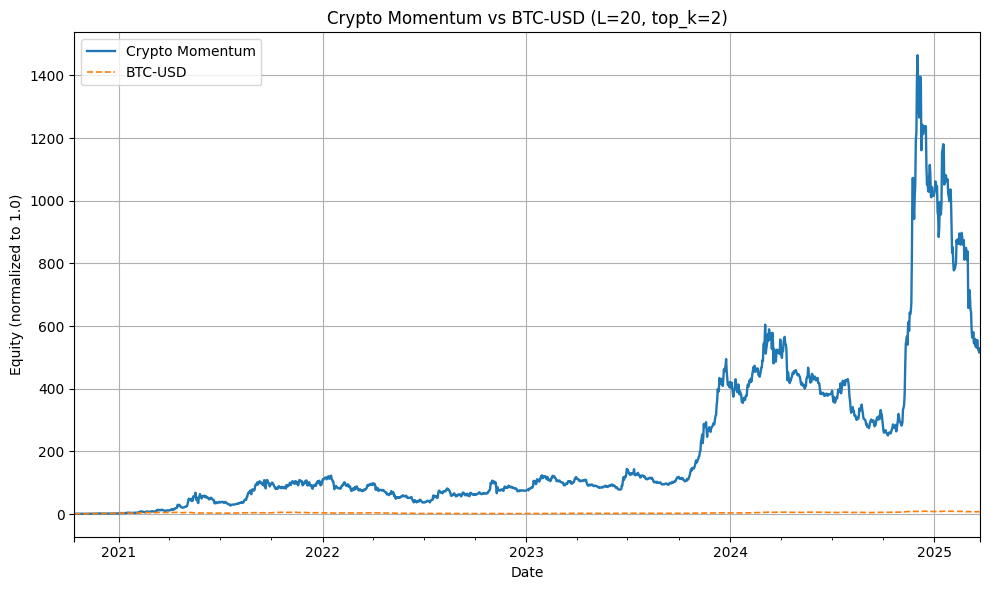

In [11]:
#!/usr/bin/env python3
# Final Crypto Momentum Model
# Fixed params: L = 20, top_k = 2
#
# Universe modes:
#   "crypto"         -> user-defined crypto list
#   "underperformers"-> user-defined crypto list, filtered to those that
#                       historically underperform BTC-USD (total return)
#
# Always:
#   - Compute daily momentum over last 20 days (compounded), shifted by 1 day
#   - Each day, go long top_k tickers by momentum, equal-weighted
#   - Compare to BTC-USD buy & hold

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
UNIVERSE_MODE = "crypto"   # "crypto" | "underperformers"

# User crypto universe (edit as you like)
CRYPTO_TICKERS = [
    "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "ADA-USD",
    "DOGE-USD", "AVAX-USD", "LINK-USD", "MATIC-USD", "DOT-USD",
    "LTC-USD", "BCH-USD", "XLM-USD", "ATOM-USD", "ETC-USD", "TRX-USD"
]

BENCH_TICKER = "BTC-USD"
START_DATE = "2015-01-01"   # BTC-USD has decent history from ~2014 onwards
TRADING_DAYS_PER_YEAR = 365

# Fixed best params
L_LOOKBACK = 20
TOP_K = 2


# ---------------- DATA ----------------
def download_prices(base_tickers, bench_ticker=BENCH_TICKER, start=START_DATE):
    """
    Download Adjusted Close prices for base_tickers + bench_ticker,
    and drop any dates where any ticker is missing (common date universe).
    """
    tickers = sorted(set(base_tickers + [bench_ticker]))

    data = yf.download(
        tickers,
        start=start,
        progress=False
    )

    if "Adj Close" in data.columns:
        px = data["Adj Close"]
    else:
        px = data["Close"]

    missing = set(tickers) - set(px.columns)
    if missing:
        raise ValueError(f"Missing price data for: {missing}")

    # Common date universe: drop rows with any NaNs
    px = px[tickers].dropna()

    return px


def compute_returns(px: pd.DataFrame) -> pd.DataFrame:
    """Simple daily returns."""
    return px.pct_change().dropna()


# ---------------- STRATEGY ----------------
def run_momentum_strategy(asset_ret: pd.DataFrame,
                          lookback: int = L_LOOKBACK,
                          top_k: int = TOP_K) -> (pd.Series, pd.Series):
    """
    Momentum strategy:
      - Momentum = compounded return over last `lookback` days, shifted by 1 day
      - Each day long the `top_k` tickers with highest momentum (equal-weight)
    Returns:
      - strategy_ret: Series of daily strategy returns
      - chosen_ticker: Series of symbol(s) chosen (if top_k > 1, stored as comma-separated string)
    """
    if lookback < 1:
        raise ValueError("lookback must be >= 1")
    if top_k < 1:
        raise ValueError("top_k must be >= 1")

    # Rolling product of (1 + r) over lookback days
    cum = (1.0 + asset_ret).rolling(lookback).apply(np.prod, raw=True) - 1.0
    # Shift one day to avoid look-ahead
    momentum = cum.shift(1).dropna(how="any")

    # Align returns
    ret = asset_ret.loc[momentum.index]

    # Rank each day
    ranks = momentum.rank(axis=1, ascending=False, method="first")

    # Binary weights for top_k
    weights = (ranks <= top_k).astype(float)
    weights = weights.div(weights.sum(axis=1), axis=0)  # equal weight top_k

    # Strategy returns: row-wise dot product
    strategy_ret = (weights * ret).sum(axis=1)
    strategy_ret.name = "Momentum_L{}_K{}".format(lookback, top_k)

    # For diagnostics: which tickers were selected
    chosen_list = []
    for dt, row in weights.iterrows():
        chosen = row[row > 0].index.tolist()
        chosen_list.append(",".join(chosen))
    chosen_ticker = pd.Series(chosen_list, index=weights.index, name="chosen")

    return strategy_ret, chosen_ticker


# ---------------- UNDERPERFORMER FILTER ----------------
def select_underperformers(px: pd.DataFrame,
                           bench_ticker: str = BENCH_TICKER,
                           min_underperformers: int = TOP_K) -> list:
    """
    From px (prices for many tickers including bench_ticker),
    select tickers whose total return over the full period
    is LOWER than the benchmark's total return.
    Returns a list of underperformer tickers.
    """
    all_tickers = list(px.columns)
    if bench_ticker not in all_tickers:
        raise ValueError(f"{bench_ticker} not in price DataFrame columns.")

    bench_px = px[bench_ticker]
    bench_ret = bench_px.iloc[-1] / bench_px.iloc[0] - 1.0

    under = []
    for t in all_tickers:
        if t == bench_ticker:
            continue
        tr = px[t].iloc[-1] / px[t].iloc[0] - 1.0
        if tr < bench_ret:
            under.append(t)

    if len(under) < min_underperformers:
        raise ValueError(
            f"Only {len(under)} underperformers found (< {min_underperformers}). "
            f"Relax the condition or expand CRYPTO_TICKERS."
        )

    return under


# ---------------- STATS ----------------
def performance_stats(ret: pd.Series, name: str = "Strategy"):
    ret = ret.dropna()
    if ret.empty:
        raise ValueError(f"No returns to evaluate for {name}.")

    equity = (1.0 + ret).cumprod()
    total_return = equity.iloc[-1] - 1.0

    n_days = ret.shape[0]
    n_years = n_days / TRADING_DAYS_PER_YEAR

    cagr = equity.iloc[-1] ** (1.0 / n_years) - 1.0 if n_years > 0 else np.nan
    vol = ret.std() * np.sqrt(TRADING_DAYS_PER_YEAR) if ret.std() > 0 else np.nan
    sharpe = (ret.mean() / ret.std()) * np.sqrt(TRADING_DAYS_PER_YEAR) if ret.std() > 0 else np.nan

    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    max_dd = dd.min()

    stats = {
        "name": name,
        "total_return": total_return,
        "CAGR": cagr,
        "ann_vol": vol,
        "Sharpe": sharpe,
        "max_drawdown": max_dd,
        "n_days": n_days,
    }
    return stats, equity


def print_stats(stats):
    print(f"\n=== {stats['name']} Performance ===")
    print(f"Days                : {stats['n_days']}")
    print(f"Total return        : {stats['total_return']*100:6.2f}%")
    print(f"CAGR                : {stats['CAGR']*100:6.2f}%")
    print(f"Annualized vol      : {stats['ann_vol']*100:6.2f}%")
    print(f"Sharpe (rf=0)       : {stats['Sharpe']:6.2f}")
    print(f"Max drawdown        : {stats['max_drawdown']*100:6.2f}%")
    print("=====================================")


# ---------------- PLOTTING ----------------
def plot_equity(equity_strategy, equity_bench,
                title="Equity Curve",
                label_strategy="Strategy",
                label_bench="BTC-USD"):
    plt.figure(figsize=(10, 6))
    (equity_strategy / equity_strategy.iloc[0]).plot(label=label_strategy, linewidth=1.7)
    (equity_bench / equity_bench.iloc[0]).plot(label=label_bench, linewidth=1.2, linestyle="--")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Equity (normalized to 1.0)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ---------------- MAIN ----------------
def main():
    # 1) Decide base universe
    if UNIVERSE_MODE == "crypto" or UNIVERSE_MODE == "underperformers":
        base_universe = CRYPTO_TICKERS.copy()
        universe_label = "Crypto"
    else:
        raise ValueError(f"Unknown UNIVERSE_MODE: {UNIVERSE_MODE}")

    # 2) Download prices for base universe + BTC-USD on a common date set
    px_all = download_prices(base_universe, bench_ticker=BENCH_TICKER, start=START_DATE)

    # 3) If using underperformers, filter the universe vs BTC-USD
    if UNIVERSE_MODE == "underperformers":
        under = select_underperformers(px_all, bench_ticker=BENCH_TICKER, min_underperformers=TOP_K)
        print(f"\nUnderperformers vs {BENCH_TICKER}: {under}")
        universe = under
        universe_label = "Underperforming Crypto"
    else:
        universe = base_universe

    # 4) Compute returns
    ret_all = compute_returns(px_all)
    universe_ret = ret_all[universe]
    bench_ret = ret_all[BENCH_TICKER]

    # 5) Run momentum strategy with fixed params (L=20, top_k=2)
    strat_ret, chosen = run_momentum_strategy(universe_ret, lookback=L_LOOKBACK, top_k=TOP_K)

    # 6) Align BTC-USD to strategy dates
    bench_aligned = bench_ret.loc[strat_ret.index]

    # 7) Performance stats
    strat_stats, strat_equity = performance_stats(
        strat_ret,
        name=f"{universe_label} Momentum (L={L_LOOKBACK}, top_k={TOP_K})"
    )
    bench_stats, bench_equity = performance_stats(
        bench_aligned,
        name=f"{BENCH_TICKER} Buy & Hold"
    )

    print_stats(strat_stats)
    print_stats(bench_stats)

    # 8) Selection frequency
    print("\nSelection frequency (by ticker):")
    counts = {}
    for row in chosen.dropna():
        for t in row.split(","):
            counts[t] = counts.get(t, 0) + 1
    counts_series = pd.Series(counts).sort_values(ascending=False)
    print(counts_series)

    # 9) Plot equity curves
    plot_equity(
        strat_equity,
        bench_equity,
        title=f"{universe_label} Momentum vs {BENCH_TICKER} (L={L_LOOKBACK}, top_k={TOP_K})",
        label_strategy=f"{universe_label} Momentum",
        label_bench=BENCH_TICKER
    )


if __name__ == "__main__":
    main()